In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
#from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import interp1d
from astropy.cosmology import Planck15
from datetime import datetime
from decimal import Decimal
from scipy import stats
from datetime import datetime
import subprocess
c = 299792458 #speed of light m s^-1
#plt.rcParams['figure.figsize'] = [20, 10]

import extinction

startTime = datetime.now()

from os.path import expanduser
home = expanduser("~")
libdir = home + '/sed_research'

In [2]:
from sedlib import read_params,sed

In [3]:
home

'/Users/cv'

In [4]:
parfile = libdir + '/params/nir.par'
tempfile = libdir + '/Templates/ARP220_loglam_lognuLnu.txt'

In [5]:
Av = 0.0
Rv = 5.0

#Initializing here, so we don't have to call the class every time

z = 1.5
mysed = sed(parfile,tempfile)

#######
mysed.extinction(Av=Av,Rv=Rv)

mysed.redshift(z)
mysed.photometry()
phot, phot_err, tag, eazytag = mysed.export_phot(program="EAZY")


In [6]:
#Not exporting templates

folder = home + "/eazy-photoz/templates/vb/"
filename = "ARP220_Av{}Rv{}.dat".format(Av,Rv)
mysed.export_template(filename,folder)

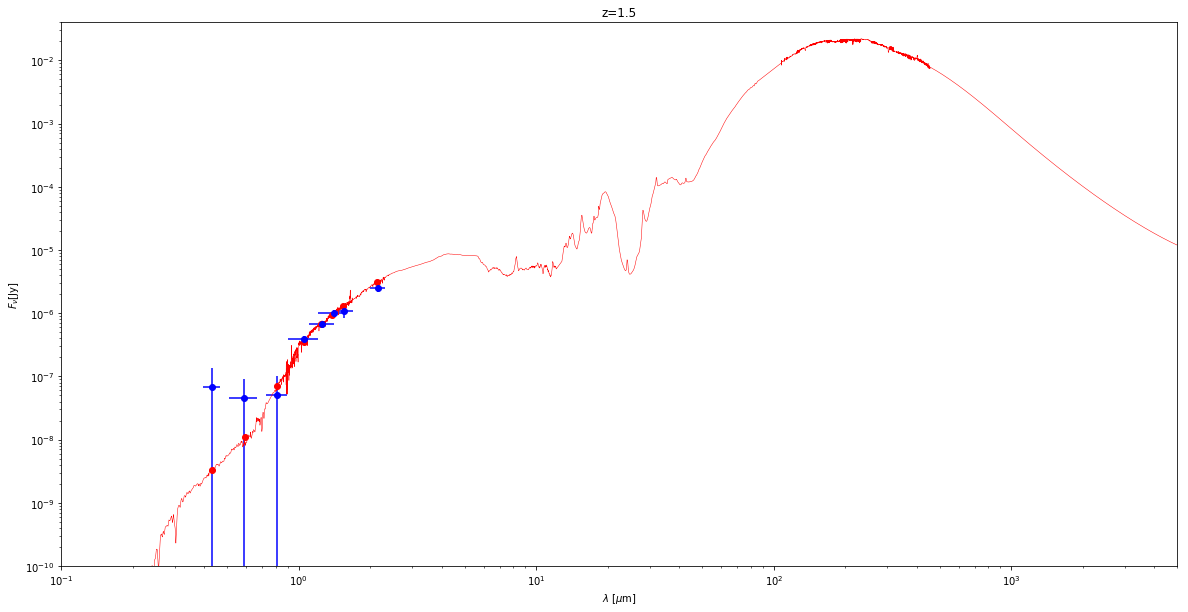

In [7]:
plt.rcParams['figure.figsize'] = [20, 10]

z = 1.5
mysed = sed(parfile,tempfile)
mysed.extinction(Av=Av,Rv=Rv)
mysed.redshift(z)
mysed.photometry()

ax = plt.subplot(111)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

plt.errorbar(mysed.lam_c, mysed.phot, xerr=mysed.lam_err, yerr=mysed.phot_err,fmt="bo",ecolor="blue")
plt.plot(mysed.lam_eff, mysed.phot_c, "ro")
mysed.plot_sed(scale="normal",color="red")
#plt.plot(mysed.lam_eff,mysed.phot_c,"ro")

#test 
#plt.errorbar(lam_c,phot_test,yerr=phot_err_test,fmt="co")

#mysed.plot_filters(1e-8)
plt.ylim(1e-10,4e-2)
plt.xlim(1e-1,5e3)
#plt.legend(loc="lower right")

plt.show()
#plt.savefig("arp220Av{}Rv{}.png".format(Av,Rv),dpi=150)

In [8]:
mysed.lam_c

[2.146, 1.4, 1.05, 0.431, 0.589, 1.545, 0.811, 1.25]

In [9]:
idx = np.argsort(mysed.lam_c)

In [10]:
idx

array([3, 4, 6, 2, 7, 1, 5, 0])

In [11]:
np.asarray(mysed.tag)[idx]

array(['F435W', 'F606W', 'F814W', 'F105W', 'F125W', 'F140W', 'F160W',
       'Ks'], dtype='|S5')

In [12]:
np.array(mysed.det)[idx]

array(['up_lim', 'up_lim', 'up_lim', 'det', 'det', 'det', 'det', 'det'],
      dtype='|S6')

In [13]:
#Translation from name to filters on EAZY FILTER.RES
eazyfolder = home + "/eazy-photoz"
with open(eazyfolder + "/inputs/zphot.translate","w") as f:
    for i in range(len(eazytag)):
        f.write("f_{} F{}\n".format(str(tag[i]),str(int(eazytag[i]))))
        f.write("e_{} E{}\n".format(str(tag[i]),str(int(eazytag[i]))))

In [14]:
#Creating a Mock catalog
zspace = np.linspace(1.,4.0,10000) #Redshift grid

In [15]:
with open(home + "/eazy-photoz/inputs/eazy.cat","w") as f:
    L = "#id"
    for i in range(len(tag)):
        L+= " f_{} e_{}".format(tag[i],tag[i])
#    f.write(L + " z_spec" + "\n")
    f.write(L + "\n")
    L = "#id"
    for i in range(len(eazytag)):
        L+= " F{} E{}".format(np.int(eazytag[i]),np.int(eazytag[i]))
#    f.write(L + " z_spec" + "\n")
    f.write(L + "\n")
    #######
    for i in range(len(zspace)):
        mysed.redshift(zspace[i])
        mysed.photometry()
        phot, phot_err, tag, eazytag = mysed.export_phot(program="EAZY")
        L = "{}".format(i+1)
        for j in range(len(phot)):
            #EAZY format for Flux is microJansky
            L += "  " + "{:.5e}".format(Decimal(str(1e6*phot[j]))) + "  " + "{:.5e}".format(Decimal(str(1e6*phot_err[j])))
#        L+= " -1.0000"
        L+= "\n"
        f.write(L)
    print "done"

done


In [16]:
#Running EAZY from here
os.chdir(home + "/eazy-photoz/inputs/")
subprocess.call("../src/eazy -p zphot.param.default",shell=True)

0

In [17]:
zout = np.loadtxt(home + "/eazy-photoz/inputs/OUTPUT/photz.zout",comments="#",usecols=(14),unpack=True)

In [18]:
zout

array([  1.4953,   1.4283,   1.6119, ..., -99.    , -99.    , -99.    ])

In [19]:
zspace[1000]

1.3000300030003

In [20]:

mask = zout>0
zout_m = zout[mask]
zspace_m = zspace[mask]

1.308556635184836 0.18573973026366897


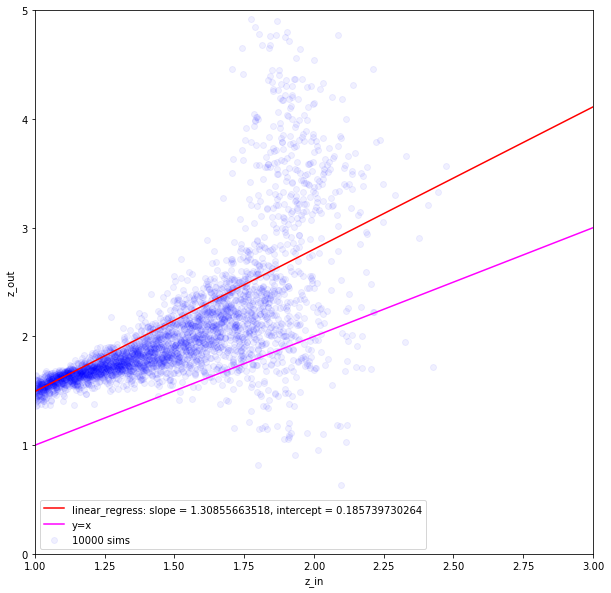

In [21]:
plt.rcParams['figure.figsize'] = [10, 10]


slope, intercept, r_value, p_value, std_err = stats.linregress(zspace_m[:300],zout_m[:300])
x = np.linspace(1.,4.0,10000)
y = slope*x+intercept
plt.plot(x,y,color="red",label="linear_regress: slope = {}, intercept = {}".format(slope,intercept))
print slope,intercept

plt.plot(x,x,color="magenta",label="y=x")

plt.xlabel("z_in")
plt.ylabel("z_out")

plt.xlim(1.,3.0)
plt.ylim(0.,5.0)

plt.scatter(zspace,zout,c="blue",alpha=0.06,label="10000 sims")
plt.legend()

plt.show()
#plt.savefig("arp220Av{}Rv{}.png".format(Av,Rv),dpi=150)

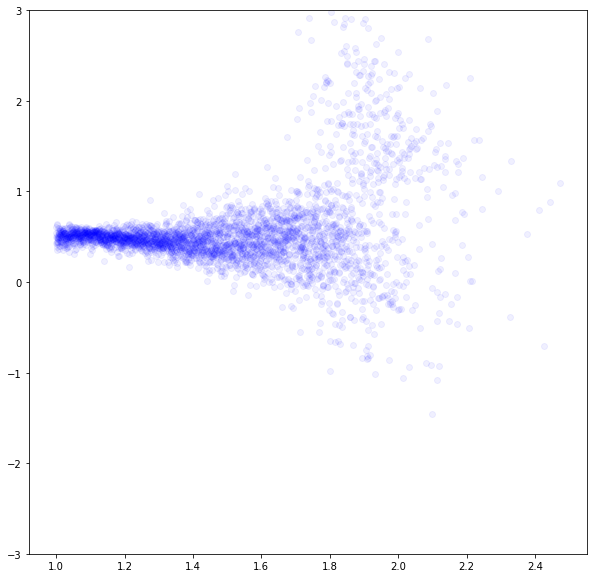

In [22]:
plt.rcParams['figure.figsize'] = [10, 10]

plt.scatter(zspace_m,zout_m-zspace_m,c="blue",alpha=0.06,label="10000 sims")
plt.ylim(-3.,3.)
plt.show()

In [23]:
bins = np.linspace(1.,2.,10)
digitized = np.digitize(zspace_m,bins)
data = zout_m-zspace_m

In [24]:
hb = []
for i in range(len(bins)-1):
    hb.append((bins[i]+bins[i+1])/2.)
hb = np.asarray(hb)
print hb
print len(hb)

[1.05555556 1.16666667 1.27777778 1.38888889 1.5        1.61111111
 1.72222222 1.83333333 1.94444444]
9


In [25]:
means = [data[digitized == i].mean() for i in range(1, len(bins))]
std = [data[digitized == i].std() for i in range(1, len(bins))]

In [26]:
means

[0.5081955276120604,
 0.49017279279279274,
 0.46705439438538443,
 0.45436165519516913,
 0.5331121621621621,
 0.5784924124034024,
 0.6621984027243695,
 0.828516615014795,
 0.9153374671644379]

In [27]:
std

[0.05899826178396923,
 0.06644398800421096,
 0.08685803728378917,
 0.2439748388738302,
 0.5885942733639516,
 0.6720025676907189,
 0.7944625389763187,
 0.9191905637067982,
 0.949688508122892]

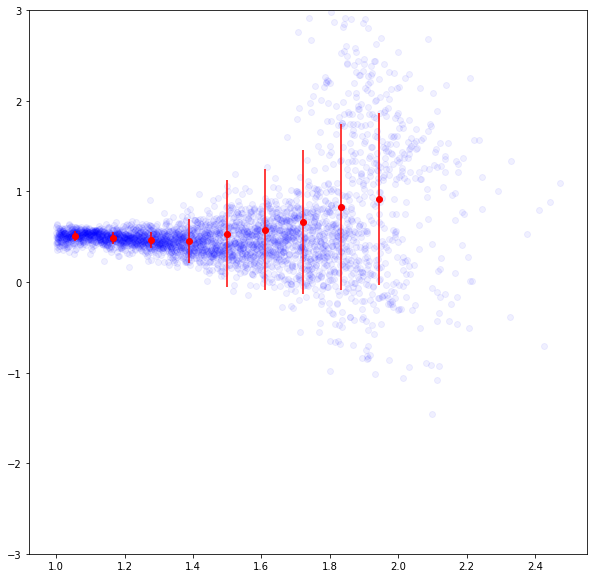

In [28]:
plt.rcParams['figure.figsize'] = [10, 10]

plt.scatter(zspace_m,zout_m-zspace_m,c="blue",alpha=0.06,label="10000 sims")
plt.errorbar(hb, means, yerr=std,fmt="ro",ecolor="red")

plt.ylim(-3.,3.)
plt.show()

In [29]:
print datetime.now() - startTime

0:07:02.023484
